In [107]:
import tskit
import tszip
import numpy as np
import pandas as pd
import stdpopsim
from numpy.random import default_rng
import msprime
import pyreadr

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [109]:
BCFTOOLS = "/home/kele/programs/bcftools/bcftools-1.11/bcftools"

In [110]:
def get_ancestry_dosage(arr, n_anc=3):
    assert (n_anc==3)
    a0 = arr[:, 0::3] # should be views
    a1 = arr[:, 1::3]
    a2 = arr[:, 2::3]
    anc_dosage = np.zeros((arr.shape[0], int(arr.shape[1]/2)), dtype=np.half)
    anc_dosage[:, 0::3] = a0[:, ::2] + a0[:, 1::2]
    anc_dosage[:, 1::3] = a1[:, ::2] + a1[:, 1::2]
    anc_dosage[:, 2::3] = a2[:, ::2] + a2[:, 1::2]
    return anc_dosage

In [111]:
def plot_ancestry_dosage(pred_dosage, start_index, reference_dosage=None):
    """
    only works for 3 ancestries
    """
    fig, ax = plt.subplots(figsize = (12, 4), nrows = 3, sharex=True, sharey=True)
    l0, = ax[0].plot(pred_dosage[:, start_index+0], c='b')
    l1, = ax[1].plot(pred_dosage[:, start_index+1], c='orange')
    l2, = ax[2].plot(pred_dosage[:, start_index+2], c='green')
    plt.legend([l0, l1, l2], ['pop0', 'pop1', 'pop2'])
    ax[0].set_title('Ancestry dosage')
    ax[2].set_xlabel('Site number ')
    
    if reference_dosage is not None:
        l0, = ax[0].plot(reference_dosage[:, start_index+0], c='b', alpha=.5, ls='--')
        l1, = ax[1].plot(reference_dosage[:, start_index+1], c='orange', alpha=.5, ls='--')
        l2, = ax[2].plot(reference_dosage[:, start_index+2], c='green', alpha=.5, ls='--')

    fig.tight_layout()
    sns.despine(bottom=True)

In [139]:
def r2_ancestry_dosage(true_dosage, pred_dosage, nanc):
    if type(pred_dosage) is pd.core.frame.DataFrame:
        pred_dosage = pred_dosage.values
    per_anc = []
    for i in range(nanc):
        per_anc.append(
            r2_score(
                y_true=true_dosage[:,i::3].ravel(),
                y_pred=pred_dosage[:,i::3].ravel()
            )
        )
    per_ind = []
    for i in range(int(true_dosage.shape[1]/nanc)):
        per_ind.append(
            r2_score(
                y_true=true_dosage[:, i*nanc:i*nanc+nanc].ravel(),
                y_pred=pred_dosage[:, i*nanc:i*nanc+nanc].ravel()
            )
        )
    
    return(per_anc, per_ind)

# True ancestry

In [120]:
def load_true_la(path):
    return np.load(path)['arr']

def get_true_anc_dosage(true_la, n_anc):
    hap1 = np.zeros((true_la.shape[0], int(true_la.shape[1]/2*n_anc)), dtype = 'int8')
    hap2 = np.zeros((true_la.shape[0], int(true_la.shape[1]/2*n_anc)), dtype = 'int8')
    aa = np.arange(true_la[:, ::2].shape[1])*n_anc+true_la[:, ::2]
    bb = np.arange(true_la[:, 1::2].shape[1])*n_anc+true_la[:, 1::2]
    np.put_along_axis(hap1, aa, 1, axis=1)
    np.put_along_axis(hap2, bb, 1, axis=1)
    return hap1+hap2

In [121]:
n_anc = 3
true_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/true_local_ancestry.site_matrix.npz"
true_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/long_run/true_local_ancestry.site_matrix.npz"


In [122]:
true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

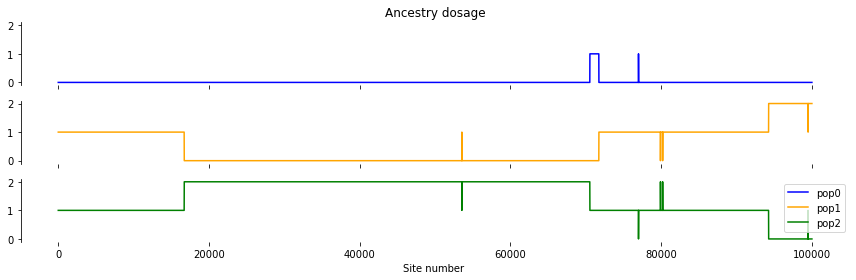

In [124]:
plot_ancestry_dosage(true_anc_dosage, start_index=3, reference_dosage=None)

## Load in the probablistic output of each method
Data frame with one row per site, 

Only every 5 sites represented in this file - not sure if it will always be intervals of 5 sites

After the index columns - each (individual) X (haplotype) X (population) has an entry. 

In [148]:
def load_rfmix_fb(path):
    rfmix_res = pd.read_csv(path, sep='\t', comment='#')
    # expand out to each site
    rfmix_res = np.repeat(rfmix_res.iloc[:, 4:].values, [5], axis = 0)
    return rfmix_res

In [149]:
rf_fb_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/RFMix2/rfmix2.fb.tsv'
rf_fb_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/long_run/RFMix2/rfmix2.fb.tsv'

In [150]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path))

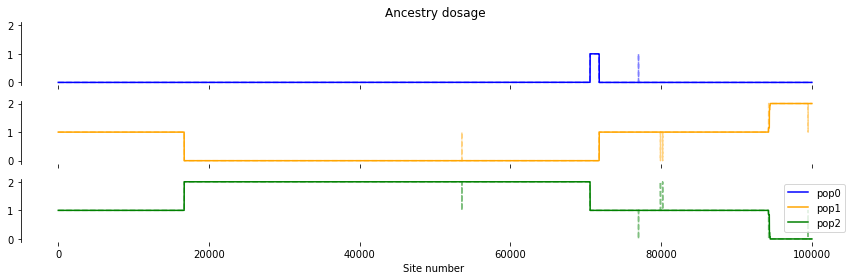

In [151]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

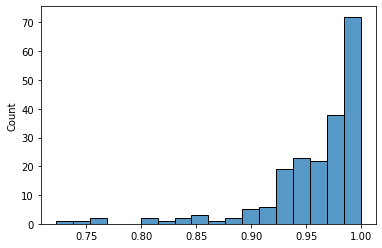

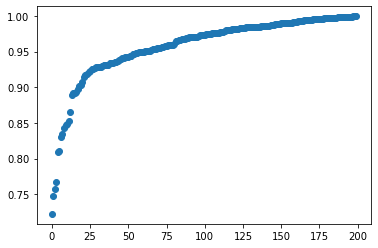

(0.9527561151967023, 0.9574373895594066)

In [153]:
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    nanc=3
)
sns.histplot(rfmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(rfmix_ind_r2)), sorted(rfmix_ind_r2))
plt.show()
np.mean(rfmix_anc_r2), np.mean(rfmix_ind_r2)

# Mosaic
Data frame with one row per site. 
after the index columns - each (individual) X (haplotype) X (ancestry) has an entry. 

In [136]:
#mosaic_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/MOSAIC/la_probabilites.3way_1-2_22-22_1204_60_0.99_100.RData'
mosaic_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/long_run/MOSAIC/la_probabilites.3way_1-200_22-22_2800_60_0.99_100.RData'
mr = pyreadr.read_r(mosaic_path)['arr'].astype(np.half)
mosaic_anc_dosage = get_ancestry_dosage(mr.to_numpy().T.reshape((mr.shape[2],-1), order='C'))

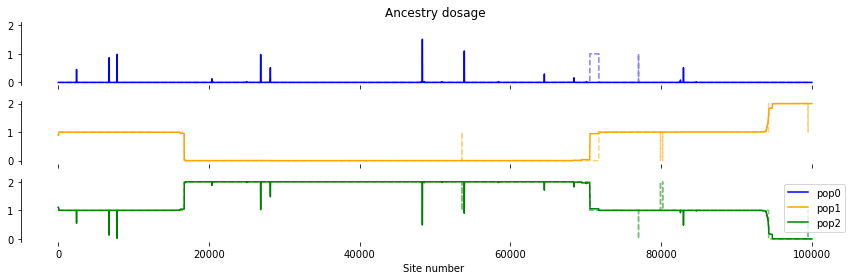

In [137]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

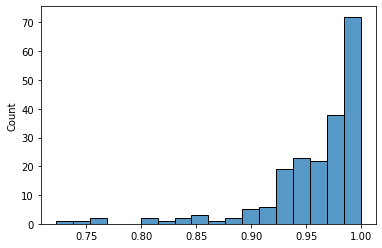

(0.9527561151967023, 0.9574373895594066)

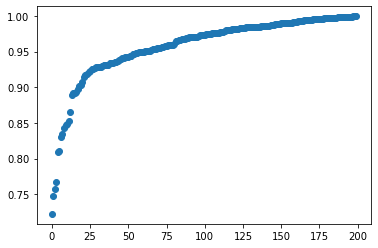

In [143]:
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    nanc=3
)
sns.histplot(mosaic_ind_r2)
plt.show()
plt.scatter(np.arange(len(mosaic_ind_r2)), sorted(mosaic_ind_r2))
np.mean(mosaic_anc_r2), np.mean(mosaic_ind_r2)

In [215]:
# I should improve this section here
mr = mr.to_dataframe(name = 'boo').reset_index()
# after this pivot, should have the same shape as the RFMIX results 
# individual X haplotype X ancestry - but notice that haplotypes are not grouped
mr = mr.pivot_table(index ='dim_2', columns = ['dim_1', 'dim_0'], values = 'boo').values
mr.shape

In [185]:
mosaic_anc_dosage = get_ancestry_dosage(mr)

In [186]:
anc_r2, ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    nanc=3
)
np.mean(anc_r2), np.mean(ind_r2)

(0.952756248581792, 0.9574374140517705)

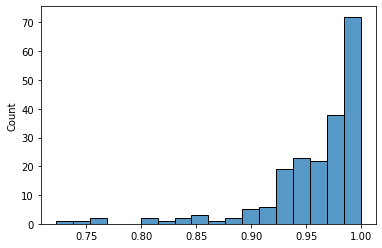

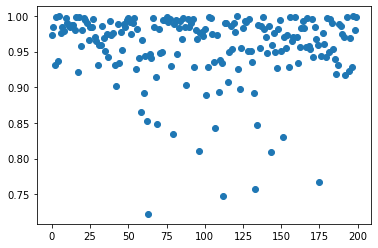

In [187]:
sns.histplot(ind_r2)
plt.show()
plt.scatter(np.arange(len(ind_r2)), ind_r2)

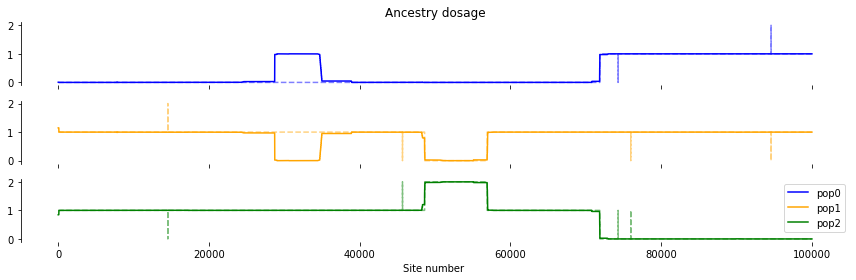

In [189]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

# bmix

In [154]:
bmixpath = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/bmix/bmix.anc.vcf.gz'
bmixpath = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/long_run/bmix/bmix.anc.vcf.gz'

In [155]:
!{BCFTOOLS} query -f '%CHROM, %POS, [%ANP1, %ANP2,]\n' {bmixpath} > {bmixpath.replace('.vcf.gz', '.csv')}

In [157]:
bmix = pd.read_csv(bmixpath.replace('.vcf.gz', '.csv'), header = None)
bmix = bmix.dropna(axis=1)
bmix = bmix.iloc[:,2:]
bmix_anc_dosage = get_ancestry_dosage(bmix.values)

In [158]:
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    nanc=3
)
np.mean(bmix_anc_r2), np.mean(bmix_ind_r2)

(0.9788792486156549, 0.9797811616797916)

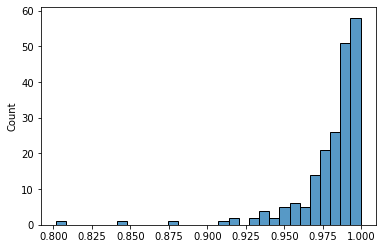

(array([132]),)

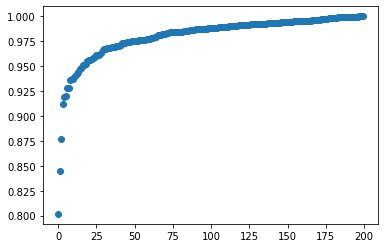

In [159]:
sns.histplot(bmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(bmix_ind_r2)), sorted(bmix_ind_r2))
np.where(bmix_ind_r2 == np.min(bmix_ind_r2))

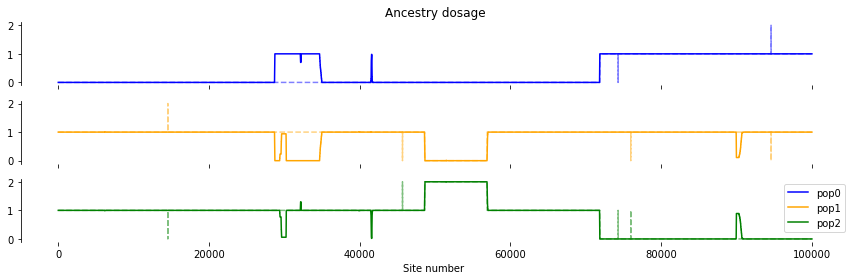

In [160]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

In [219]:
# check positions are maintained
b = pd.read_csv(bmixpath, skiprows=9, sep='\t')
# compare the positions in the bmix results with the positions of all sites?
positions = pd.read_csv('/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/site.positions', 
            header = None)
positions = pd.read_csv('/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/long_run/site.positions', 
            header = None)
set(positions[0].values) - set(b.POS.values)

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,pop_3-ind_0001,...,pop_3-ind_0191,pop_3-ind_0192,pop_3-ind_0193,pop_3-ind_0194,pop_3-ind_0195,pop_3-ind_0196,pop_3-ind_0197,pop_3-ind_0198,pop_3-ind_0199,pop_3-ind_0200
0,chr22,155,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:0:1:1,0,0:0,1,0",...,"0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:2:1:0,0,1:0,1,0","0|0:2:2:0,0,1:0,0,1","0|0:2:0:0,0,1:1,0,0","0|0:1:1:0,1,0:0,1,0","0|0:2:2:0,0,1:0,0,1","0|0:0:1:1,0,0:0,1,0","0|0:1:0:0,1,0:1,0,0","0|0:1:2:0,0.77,0.23:0,0,1"
1,chr22,1494,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:0:1:1,0,0:0,1,0",...,"0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:2:1:0,0,1:0,1,0","0|0:2:2:0,0,1:0,0,1","0|0:2:0:0,0,1:1,0,0","0|0:1:1:0,1,0:0,1,0","0|0:2:2:0,0,1:0,0,1","0|0:0:1:1,0,0:0,1,0","0|0:1:0:0,1,0:1,0,0","0|0:1:2:0,0.77,0.23:0,0,1"
2,chr22,1846,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:0:1:1,0,0:0,1,0",...,"0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:2:1:0,0,1:0,1,0","0|0:2:2:0,0,1:0,0,1","0|0:2:0:0,0,1:1,0,0","0|0:1:1:0,1,0:0,1,0","0|0:2:2:0,0,1:0,0,1","0|0:0:1:1,0,0:0,1,0","0|0:1:0:0,1,0:1,0,0","0|0:1:2:0,0.77,0.23:0,0,1"
3,chr22,1873,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:0:1:1,0,0:0,1,0",...,"0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:2:1:0,0,1:0,1,0","0|0:2:2:0,0,1:0,0,1","0|0:2:0:0,0,1:1,0,0","0|0:1:1:0,1,0:0,1,0","0|0:2:2:0,0,1:0,0,1","0|0:0:1:1,0,0:0,1,0","0|0:1:0:0,1,0:1,0,0","0|0:1:2:0,0.77,0.23:0,0,1"
4,chr22,2513,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:0:1:1,0,0:0,1,0",...,"0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:2:1:0,0,1:0,1,0","0|0:2:2:0,0,1:0,0,1","0|0:2:0:0,0,1:1,0,0","0|0:1:1:0,1,0:0,1,0","0|0:2:2:0,0,1:0,0,1","0|0:0:1:1,0,0:0,1,0","0|0:1:0:0,1,0:1,0,0","0|0:1:2:0,0.77,0.23:0,0,1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,chr22,51300837,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:2:0:0,0,1:1,0,0",...,"0|0:2:0:0,0,1:0.97,0,0.03","0|0:2:2:0,0,1:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|1:1:2:0,1,0:0,0,1","0|0:0:1:1,0,0:0,1,0","0|0:1:2:0,1,0:0,0,1","0|0:0:2:1,0,0:0.01,0,0.99","0|0:2:2:0,0.04,0.96:0,0,1"
99996,chr22,51302848,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:2:0:0,0,1:1,0,0",...,"0|0:2:0:0,0,1:0.97,0,0.03","0|0:2:2:0,0,1:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:0:1:1,0,0:0,1,0","0|0:1:2:0,1,0:0,0,1","0|0:0:2:1,0,0:0.01,0,0.99","0|0:2:2:0,0.04,0.96:0,0,1"
99997,chr22,51303136,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:2:0:0,0,1:1,0,0",...,"0|0:2:0:0,0,1:0.97,0,0.03","0|0:2:2:0,0,1:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:0:1:1,0,0:0,1,0","0|0:1:2:0,1,0:0,0,1","0|0:0:2:1,0,0:0.01,0,0.99","0|0:2:2:0,0.04,0.96:0,0,1"
99998,chr22,51303841,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:2:0:0,0,1:1,0,0",...,"0|0:2:0:0,0,1:0.97,0,0.03","0|0:2:2:0,0,1:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1","0|0:0:1:1,0,0:0,1,0","0|0:1:2:0,1,0:0,0,1","0|0:0:2:1,0,0:0.01,0,0.99","0|0:2:2:0,0.04,0.96:0,0,1"


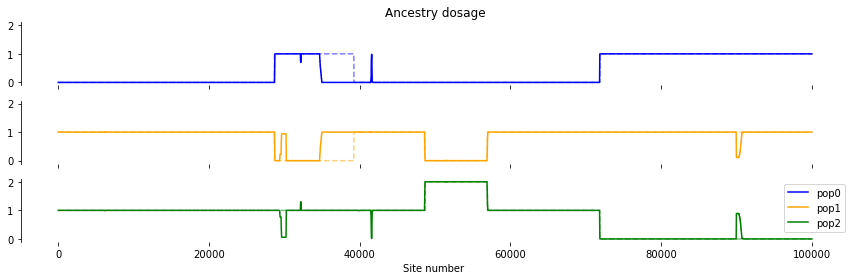

In [210]:
# comparing bmix vs rfmix
plot_ancestry_dosage(bmix_anc_dosage, start_index=62*3, reference_dosage=rfmix_anc_dosage)

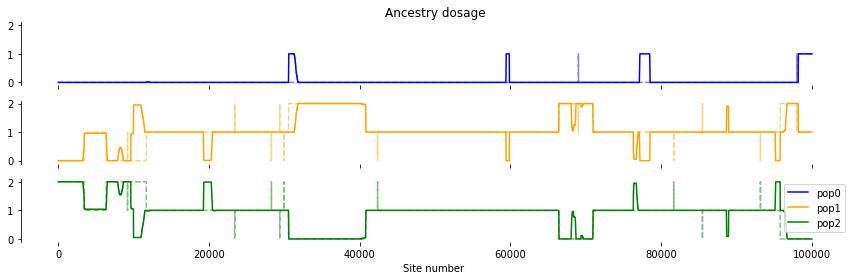

In [213]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=132*3, reference_dosage=true_anc_dosage)

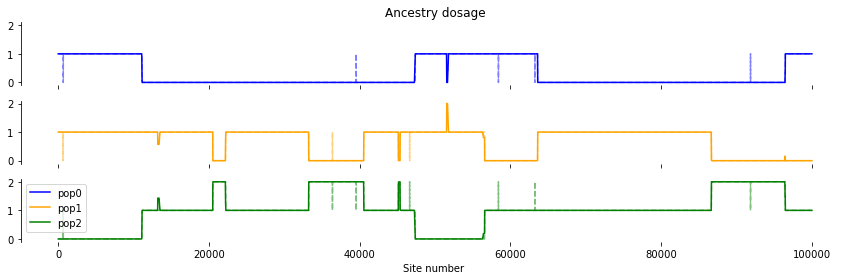

In [214]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=0, reference_dosage=true_anc_dosage)

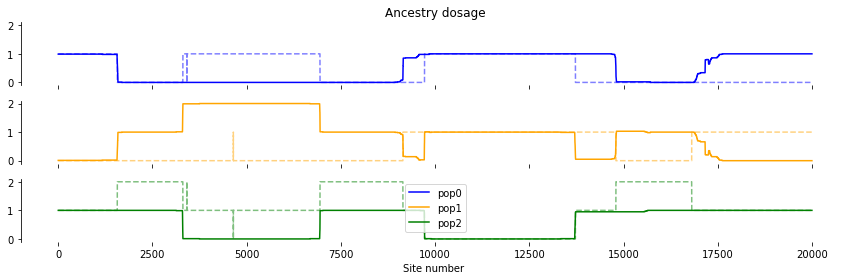

In [113]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

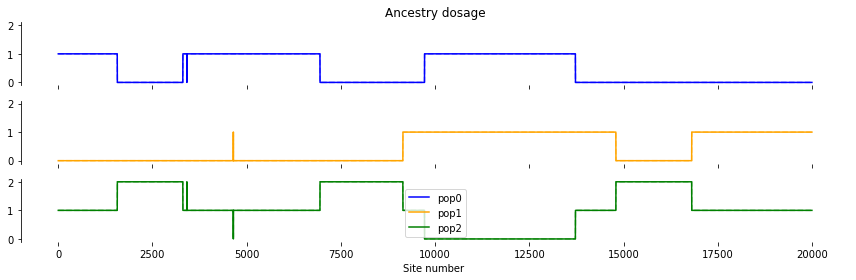

In [114]:
plot_ancestry_dosage(true_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

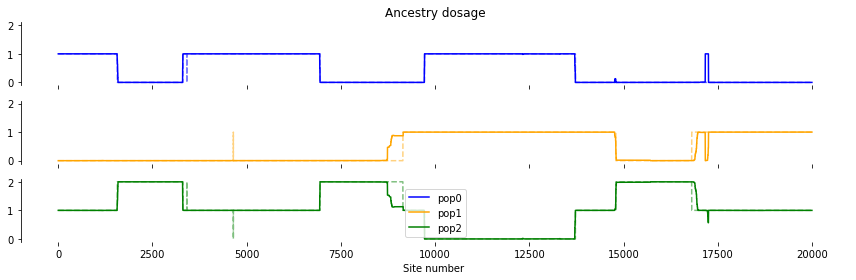

In [115]:
plot_ancestry_dosage(mosaic_anc_dosage.values, start_index=3, reference_dosage=true_anc_dosage)

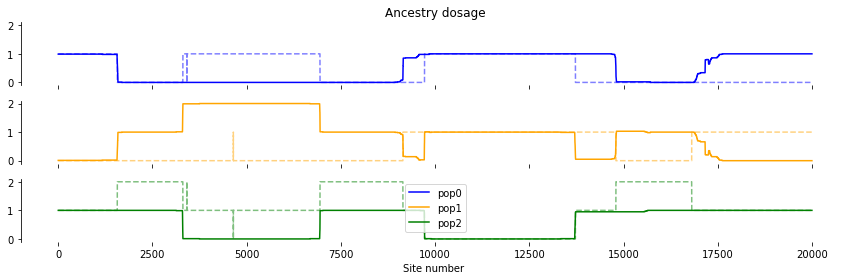

In [116]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

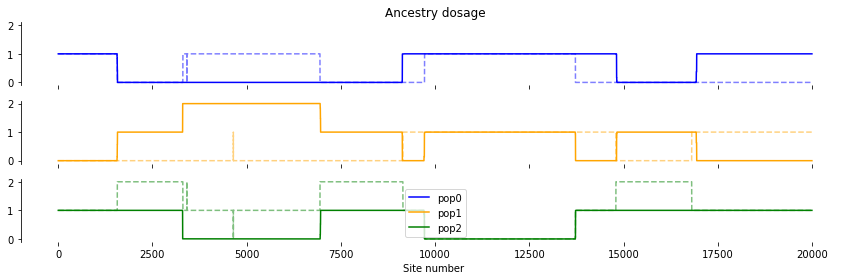

In [117]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

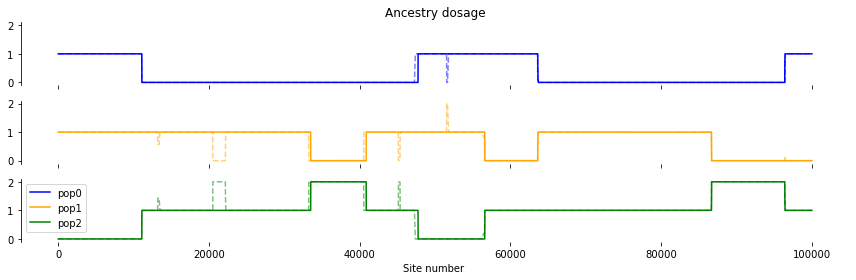

In [223]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=0, reference_dosage=bmix_anc_dosage)

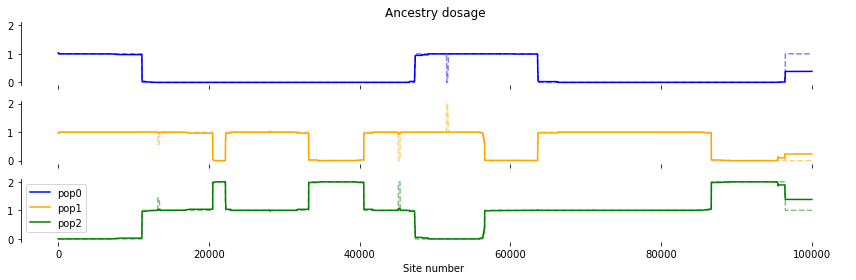

In [224]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=0, reference_dosage=bmix_anc_dosage)

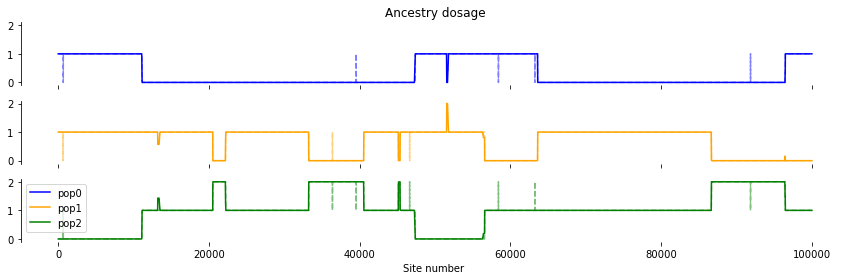

In [225]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=0, reference_dosage=true_anc_dosage)

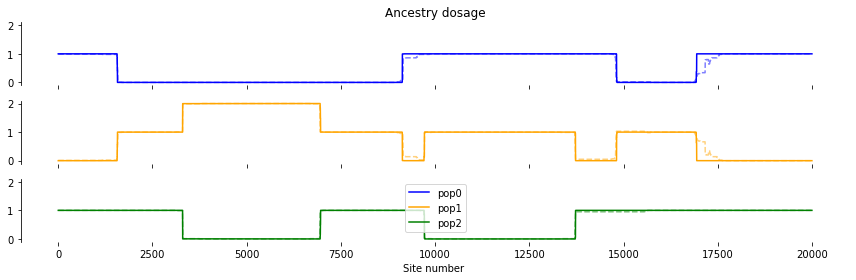

In [118]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, reference_dosage=bmix_anc_dosage)

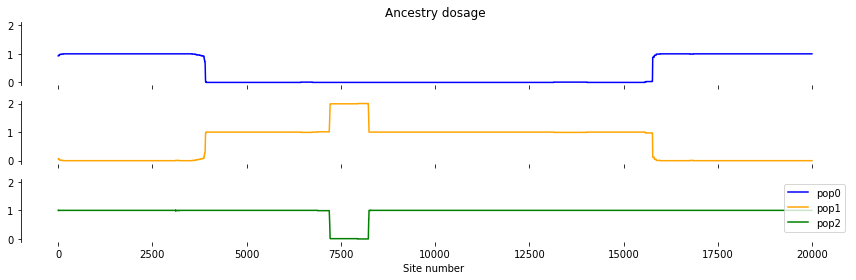

In [68]:
fig, ax = plt.subplots(figsize = (12, 4), nrows = 3, sharex=True, sharey=True)
l0, = ax[0].plot(bmix_anc_dosage[:, 0], c='b')
l1, = ax[1].plot(bmix_anc_dosage[:, 1], c='orange')
l2, = ax[2].plot(bmix_anc_dosage[:, 2], c='green')
#ax[0].set_ylim(-.1,2.2)
#ax[1].set_ylim(-.1,2.2)
#ax[2].set_ylim(-.1,2.2)
plt.legend([l0, l1, l2], ['pop0', 'pop1', 'pop2'])
ax[0].set_title('Ancestry dosage')
ax[2].set_xlabel('Site number ')

fig.tight_layout()
sns.despine(bottom=True)

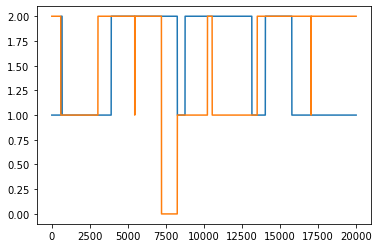

In [21]:
import matplotlib.pyplot as plt
plt.plot(true_array[:,0])
plt.plot(true_array[:,1])

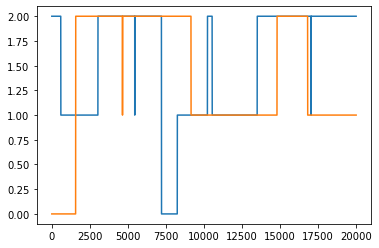

In [30]:
plt.plot(np.arange(len(true_array)), true_array[:,1])
plt.plot(np.arange(len(true_array)), true_array[:,2])

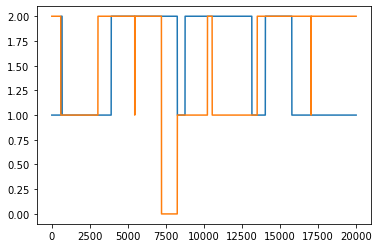

In [24]:
plt.plot(true_array[:,:2])

In [233]:
type(mosaic_anc_dosage)

pandas.core.frame.DataFrame

In [157]:
def r2_ancestry_dosage(true_dosage, pred_dosage, nanc):
    if type(pred_dosage) is pd.core.frame.DataFrame:
        pred_dosage = pred_dosage.values
    per_anc = []
    for i in range(nanc):
        per_anc.append(
            r2_score(
                y_true=true_dosage[:,i::3].ravel(),
                y_pred=pred_dosage[:,i::3].ravel()
            )
        )
    per_ind = []
    for i in range(int(true_dosage.shape[1]/nanc)):
        per_ind.append(
            r2_score(
                y_true=true_dosage[:, i*nanc:i*nanc+nanc].ravel(),
                y_pred=pred_dosage[:, i*nanc:i*nanc+nanc].ravel()
            )
        )
    
    return(per_anc, per_ind)

In [168]:
anc_r2, ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage,
    nanc=3
)
np.mean(anc_r2), np.mean(ind_r2)

(0.9660641193685594, 0.9674452179825239)

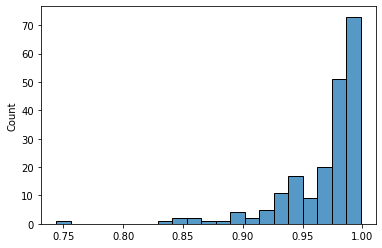

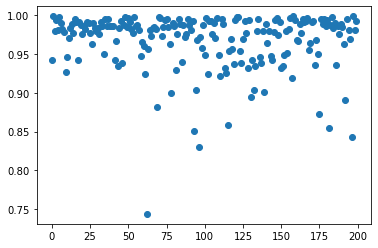

In [172]:
sns.histplot(ind_r2)
plt.show()
plt.scatter(np.arange(len(ind_r2)), ind_r2)

In [162]:
np.where(ind_r2==np.min(ind_r2))

(array([62]),)

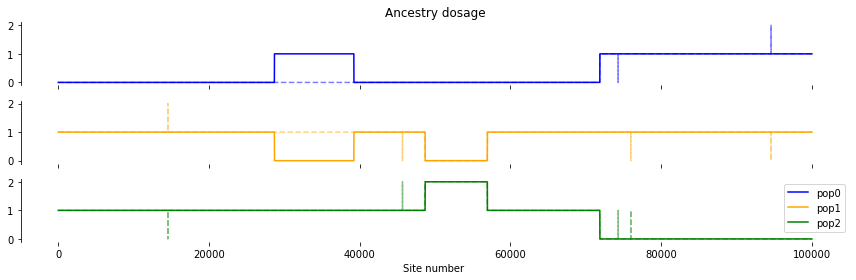

In [163]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

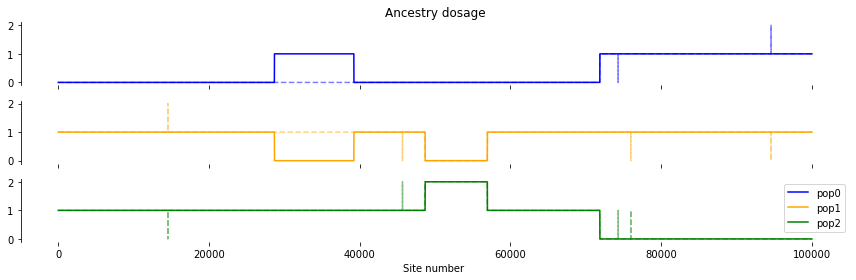

In [167]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

In [133]:
r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    nanc=3
)

NameError: name 'bmix_anc_dosage' is not defined

In [130]:
true_anc_dosage[:,0::3].ravel()

array([0., 1., 0., ..., 0., 0., 0.])

In [135]:
from scipy.stats import pearsonr

In [139]:
pearsonr(true_anc_dosage[:,0::3].ravel(), rfmix_anc_dosage[:,0::3].ravel())[0]**2
#pearsonr(true_anc_dosage[:,1::3].ravel(), rfmix_anc_dosage[:,1::3].ravel())[0]**2
#pearsonr(true_anc_dosage[:,2::3].ravel(), rfmix_anc_dosage[:,2::3].ravel())

0.9750493354079091

In [137]:
0.9788185417696803**2

0.9580857377121234

In [129]:
r2_ancestry_dosage(
    true_dosage=mosaic_anc_dosage.values, 
    pred_dosage=bmix_anc_dosage,
    nanc=3
)

[-1.216697565260898, -2.2279863410809213, -0.05957379454651868]

In [122]:
r2_score(true_anc_dosage[:,1::3].ravel(), bmix_anc_dosage[:,1::3].ravel())

NameError: name 'r2_score' is not defined

<AxesSubplot:>

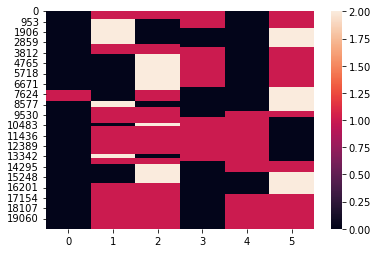

In [282]:
sns.heatmap(true_anc_dosage)

<AxesSubplot:xlabel='dim_0', ylabel='dim_2'>

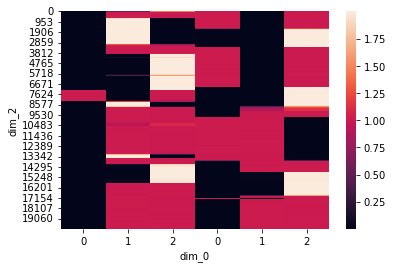

In [283]:
sns.heatmap(mosaic_anc_dosage)

<AxesSubplot:>

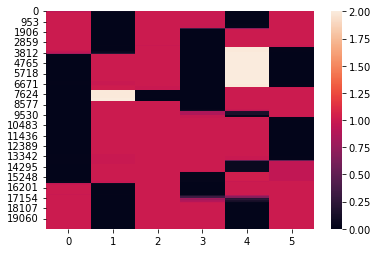

In [284]:
sns.heatmap(bmix_anc_dosage)

<AxesSubplot:>

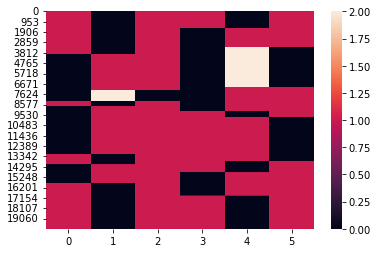

In [285]:
sns.heatmap(rfmix_anc_dosage)

In [279]:
true_anc_dosage[:,1::3].sum()

25681.0

In [280]:
bmix_anc_dosage[:,1::3].sum()

30632.620000000003

In [277]:
mosaic_anc_dosage.values[:,1::3].sum()

26208.498824220755

In [275]:
mosaic_anc_dosage.values.sum()

80000.0

In [265]:
mosaic_r2 = r2_ancestry_dosage(true_anc_dosage, mosaic_anc_dosage, nanc=3)
bmix_r2 = r2_ancestry_dosage(true_anc_dosage, bmix_anc_dosage, nanc=3)
rfmix2_r2 = r2_ancestry_dosage(true_anc_dosage, rfmix_anc_dosage, nanc=3) 
print(np.mean(mosaic_r2), np.mean(bmix_r2), np.mean(rfmix2_r2))

0.9624337278193256 -1.1662472442413503 -1.3207360609186107


[-1.2315085214457735, -2.203061575977422, -0.06417163530085501]

In [189]:
# i think this is the appropriate way to calculate
anc1 = r2_score(y_true=true_anc_dosage[:,::3].ravel() , y_pred= mosaic_anc_dosage.values[:,::3].ravel())
anc2 = r2_score(y_true=true_anc_dosage[:,1::3].ravel() , y_pred= mosaic_anc_dosage.values[:,1::3].ravel())
anc3 = r2_score(y_true=true_anc_dosage[:,2::3].ravel(), y_pred= mosaic_anc_dosage.values[:,2::3].ravel())
anc1, anc2, anc3, np.mean([anc1, anc2, anc3])

(0.985914923271034, 0.9453030708449982, 0.9560831893419446, 0.9624337278193256)

In [157]:


r2_score(y_true=anc_dosage, y_pred= mosaic_anc_dosage.values)

0.9584521922578167

In [22]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, dtype = 'int8')
b = enc.fit_transform(true_array[:,0].reshape(-1, 1))
b

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int8)

In [158]:
# i think this is the appropriate way to calculate
anc1 = r2_score(y_true=anc_dosage[:,::3].ravel() , y_pred= mosaic_anc_dosage.values[:,::3].ravel())
anc2 = r2_score(y_true=anc_dosage[:,1::3].ravel() , y_pred= mosaic_anc_dosage.values[:,1::3].ravel())
anc3 = r2_score(y_true=anc_dosage[:,2::3].ravel(), y_pred= mosaic_anc_dosage.values[:,2::3].ravel())
anc1, anc2, anc3, np.mean([anc1, anc2, anc3])

(0.985914923271034, 0.9453030708449982, 0.9560831893419446, 0.9624337278193256)

In [150]:
r2_score(y_true=anc_dosage[:,::3].ravel() , y_pred= mosaic_anc_dosage.values[:,::3].ravel())

0.985914923271034

In [139]:
mosaic_anc_dosage.values[:,::3]

array([[2.96018848e-05, 9.99712848e-01],
       [2.96330236e-05, 9.99999839e-01],
       [2.96330236e-05, 9.99999839e-01],
       ...,
       [7.60560589e-07, 1.87444230e-04],
       [7.60560589e-07, 1.87444230e-04],
       [7.60560589e-07, 1.87444230e-04]])

# Scoring rules

In [23]:
# inferences
p1 = np.array([0.1, 0.8, 0.1])
p2 = np.array([0.9, 0.1, 0.0])
# truth
t1 = np.array([1, 0, 0])
t2 = np.array([0, 1, 0])

In [25]:
# RMSD integrating over phasing
err = np.array([(t1-p1).max(), (t1-p2).max(), (t2-p1).max(), (t2-p2).max()])
np.sqrt(np.sum(err**2)/4)
np.sum(err**2)/4

0.41750000000000004

In [26]:
# weighted diploid RMSD

In [27]:
import collections
prob_of_diploid = collections.defaultdict(float)
for a1 in [0,1,2]:
    for a2 in [0,1,2]:
        prob_of_diploid[frozenset([a1, a2])] += p1[a1] * p2[a2]
prob_of_diploid

defaultdict(float,
            {frozenset({0}): 0.09000000000000001,
             frozenset({0, 1}): 0.7300000000000001,
             frozenset({0, 2}): 0.09000000000000001,
             frozenset({1}): 0.08000000000000002,
             frozenset({1, 2}): 0.010000000000000002,
             frozenset({2}): 0.0})

In [28]:
true_of_diploid = collections.defaultdict(float)
for a1 in [0,1,2]:
    for a2 in [0,1,2]:
        true_of_diploid[frozenset([a1, a2])] += t1[a1] * t2[a2]
true_of_diploid

defaultdict(float,
            {frozenset({0}): 0.0,
             frozenset({0, 1}): 1.0,
             frozenset({0, 2}): 0.0,
             frozenset({1}): 0.0,
             frozenset({1, 2}): 0.0,
             frozenset({2}): 0.0})

In [29]:
weighted_dif = 0
weights = np.zeros(9)
difs = np.zeros(9)
i = 0
for a1 in [0,1,2]:
    for a2 in [0,1,2]:
        a = frozenset([a1, a2])
        weight = len(frozenset([0, 1]) - a)
        weights[i] = weight
        difference = (prob_of_diploid[a] - true_of_diploid[a])**2
        difs[i] = difference
        print(a, weight, difference)
        i+=1
# normalize weights
weights = weights/np.sum(weights)
print(weights, difs)
weighted_dif  = np.sum(weights*difs)
np.sqrt(weighted_dif)

frozenset({0}) 1 0.008100000000000001
frozenset({0, 1}) 0 0.07289999999999995
frozenset({0, 2}) 1 0.008100000000000001
frozenset({0, 1}) 0 0.07289999999999995
frozenset({1}) 1 0.006400000000000003
frozenset({1, 2}) 1 0.00010000000000000005
frozenset({0, 2}) 1 0.008100000000000001
frozenset({1, 2}) 1 0.00010000000000000005
frozenset({2}) 2 0.0
[0.125 0.    0.125 0.    0.125 0.125 0.125 0.125 0.25 ] [0.0081 0.0729 0.0081 0.0729 0.0064 0.0001 0.0081 0.0001 0.    ]


0.06214901447328027

### The MOSAIC paper does something different.
To measure "accuracy" of its inferences in diploids, it uses r2 - the "coefficient of determination". The sum of the  haploid probabiltes for each ancestry to form a diploid ancestry vector (something like an ancestry dosage?). Within each ancestry the correlation between the diploid vectors (across sites and all individuals) is calculated.  The overall "accuracy" is the mean of these r2 values taken across all ancestries.

In [5]:
ts = tszip.decompress('/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/full.tsz') 

In [11]:
ts = tszip.decompress('/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/sample.tsz')


In [14]:
for tree in ts.trees():
    for site in tree.sites():
        assert len(site.mutations) == 1  # Only supports infinite sites muts.

In [17]:
r = np.load(file = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/true_local_ancestry.site_matrix.npz')['arr']
r.shape

(20000, 4)

In [18]:
r

array([[1, 2, 0, 2],
       [1, 2, 0, 2],
       [1, 2, 0, 2],
       ...,
       [1, 2, 1, 2],
       [1, 2, 1, 2],
       [1, 2, 1, 2]], dtype=int8)

In [13]:
msprime.__version__

'1.0.2'

In [13]:
path2 = '/home/kele/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/short_run/la_probabilites.3way_1-2_22-22_1204_60_0.99_100.RData'

result = pyreadr.read_r(path2, 
                       # use_objects=["loaclanc"]
                       )
result

OrderedDict([('arr',
              <xarray.DataArray (dim_0: 3, dim_1: 4, dim_2: 20000)>
              array([[[5.78835197e-03, 5.78305947e-03, 5.77814001e-03, ...,
                       9.42991885e-07, 9.42991885e-07, 9.42991885e-07],
                      [7.50196956e-06, 7.48607410e-06, 7.48297174e-06, ...,
                       3.78644827e-05, 3.78644827e-05, 3.78644827e-05],
                      [9.99500548e-01, 9.99750142e-01, 9.99999716e-01, ...,
                       2.43056421e-04, 2.43056421e-04, 2.43056421e-04],
                      [3.19046761e-04, 3.14161498e-04, 3.09360691e-04, ...,
                       1.14044049e-04, 1.14044049e-04, 1.14044049e-04]],
              
                     [[8.47725965e-01, 8.48558121e-01, 8.49311944e-01, ...,
                       9.91391038e-01, 9.91391038e-01, 9.91391038e-01],
                      [1.61227473e-02, 1.60330609e-02, 1.60250186e-02, ...,
                       6.90445000e-04, 6.90445000e-04, 6.90445000e-04],
       

In [19]:
result = pyreadr.read_r(path2, 
                       use_objects=["arr"]
                       )
result['arr'][:, : , 0:3].sum('dim_0')
# ancestries * haploid chromosomes * sites 

<xarray.DataArray (dim_1: 4, dim_2: 3)>
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])
Dimensions without coordinates: dim_1, dim_2

In [33]:
anc_prob.data[anc_prob.data>threshold].shape

(78169,)

In [38]:
threshold = 0.9
anc_prob = result['arr'].data.copy()
anc_prob[anc_prob>threshold,] = 1
anc_prob[anc_prob<=threshold] = 0
anc_calls = anc_prob.astype(int)
anc_calls.shape

(3, 4, 20000)

In [25]:
# over mean ancestries (over individuals)
result['arr'][:, : , 0:3].mean(['dim_1', 'dim_2'])


<xarray.DataArray (dim_0: 3)>
array([0.25146375, 0.21700147, 0.53153478])
Dimensions without coordinates: dim_0

In [15]:
import pandas as pd
import numpy as np
PATH = "/home/kele/Documents/lai/lai-sim/results/RFMix2/AmericanAdmixture_4B11/AA_42/short_run.rfmix2.fb.tsv"
lai = pd.read_csv(PATH, comment = '#', sep = '\t')
lai = lai.set_index(['chromosome',  'genetic_position', 'genetic_marker_index'])
lai = lai.melt(id_vars = ['physical_position'])
threshold =.9
lai[['name', 'hap', 'pop']] = lai['variable'].str.split(':::', expand=True)
lai['calls'] = lai['value'] > threshold

calls = lai.pivot_table(index = ['physical_position', 'name', 'hap', 'pop'], values = 'calls').reset_index()
lai_calls = calls.query('calls == True').pivot(index = ['physical_position'], columns = ['name', 'hap', 'calls'])
lai_calls = lai_calls.replace('pop_0', 0).replace('pop_1', 1).replace('pop_2', 2).replace('pop_3', 3).replace(np.NaN, -1).astype(int)

haploid_calls_1 = lai_calls.values[:, ::2]
haploid_calls_2 = lai_calls.values[:, 1::2]

highpop = np.maximum(lai_calls.values[:, ::2], lai_calls.values[:, 1::2])
lowpop = np.minimum(lai_calls.values[:, ::2], lai_calls.values[:, 1::2])

lai_calls_diploid = lowpop + highpop*10

In [16]:
lai_calls.columns.get_level_values(1).values[::2]

array(['pop_3-ind_0001', 'pop_3-ind_0002'], dtype=object)

In [5]:
# save as numpy vs hdf

In [11]:
np.save(file = '/home/kele/save_test.npy', arr = lai_calls_diploid)
np.savez_compressed(file = '/home/kele/save_test.npz', arr = lai_calls_diploid)

In [39]:
df = pd.DataFrame(lai_calls_diploid)
df.index = lai_calls.index
df.columns = lai_calls.columns.get_level_values(1).values[::2]
df.to_hdf('/home/kele/save_test.h5', key = 'la', mode = 'w', 
          complib = 'blosc:lz4hc', complevel = 9)

In [38]:
lai.sort_values([ 'physical_position', 'pop', 'name', 'hap', ])

,physical_position,variable,value,name,hap,pop,calls
0,2096,pop_3-ind_0001:::hap1:::pop_0,0.0,pop_3-ind_0001,hap1,pop_0,False
12000,2096,pop_3-ind_0001:::hap2:::pop_0,0.0,pop_3-ind_0001,hap2,pop_0,False
24000,2096,pop_3-ind_0002:::hap1:::pop_0,1.0,pop_3-ind_0002,hap1,pop_0,True
36000,2096,pop_3-ind_0002:::hap2:::pop_0,0.0,pop_3-ind_0002,hap2,pop_0,False
4000,2096,pop_3-ind_0001:::hap1:::pop_1,1.0,pop_3-ind_0001,hap1,pop_1,True
...,...,...,...,...,...,...,...
43999,51293285,pop_3-ind_0002:::hap2:::pop_1,0.0,pop_3-ind_0002,hap2,pop_1,False
11999,51293285,pop_3-ind_0001:::hap1:::pop_2,0.0,pop_3-ind_0001,hap1,pop_2,False
23999,51293285,pop_3-ind_0001:::hap2:::pop_2,1.0,pop_3-ind_0001,hap2,pop_2,True
35999,51293285,pop_3-ind_0002:::hap1:::pop_2,0.0,pop_3-ind_0002,hap1,pop_2,False


In [37]:
lai.sort_values([ 'physical_position', 'pop', 'name', 'hap', ])['value'].values.reshape((-1, 3,4))[3]

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 1.]])

# how to convert these LAI intervals used by RFmix2 into the LA at each site 

In [81]:
plinkmap = pd.read_csv('/home/kele/Dropbox/Documents/lai/lai-sim/results/local_ancestry/AmericanAdmixture_4B11/AA_42/short_run.plink_map.txt', 
                      sep = '\t', header = None)
plinkmap.columns = ['chr', 'id', 'gpos', 'bp']
plinkmap.head()

,chr,id,gpos,bp
0,chr22,.,0.003028,2096
1,chr22,.,0.020609,14267
2,chr22,.,0.031071,21510
3,chr22,.,0.038986,26989
4,chr22,.,0.039562,27388


In [83]:
lai = pd.read_csv(PATH, comment = '#', sep = '\t')
bins_left = lai['genetic_marker_index'].values
bins_right = lai['genetic_marker_index'][1:].values
# add the final bin
bins_right = np.concatenate([bins_right, [plinkmap.index.values[-1]+1]])

site_indexes = plinkmap.index.values[:,None]
mask = (bins_left <= site_indexes) & (bins_right > site_indexes)

mask.shape

(20000, 4000)

In [86]:
# CRF index of each site
crf_of_site = np.where(mask)[1]
len(crf_of_site)

20000

# LA at each site

In [115]:
lai_sites = lai.iloc[crf_of_site].copy()
lai_sites['bp'] = plinkmap['bp'].values
lai_sites['gpos'] = plinkmap['gpos'].values
lai_sites = lai_sites.drop(['physical_position', 'genetic_marker_index', 'chromosome', 'genetic_position'], axis = 1)

lai_sites = lai_sites.melt(id_vars = ['bp', 'gpos'])
lai_sites[['name', 'hap', 'pop']] = lai_sites['variable'].str.split(':::', expand=True)
lai_sites = lai_sites.drop(['variable'], axis = 1)
lai_sites

,bp,gpos,value,name,hap,pop
0,2096,0.003028,0.0,pop_3-ind_0001,hap1,pop_0
1,14267,0.020609,0.0,pop_3-ind_0001,hap1,pop_0
2,21510,0.031071,0.0,pop_3-ind_0001,hap1,pop_0
3,26989,0.038986,0.0,pop_3-ind_0001,hap1,pop_0
4,27388,0.039562,0.0,pop_3-ind_0001,hap1,pop_0
...,...,...,...,...,...,...
239995,51293285,74.093267,1.0,pop_3-ind_0002,hap2,pop_2
239996,51293990,74.094285,1.0,pop_3-ind_0002,hap2,pop_2
239997,51294013,74.094319,1.0,pop_3-ind_0002,hap2,pop_2
239998,51295267,74.096130,1.0,pop_3-ind_0002,hap2,pop_2


In [221]:
# sites * pops * haps
lai_mat = lai_sites.sort_values(['bp', 'pop', 'name', 'hap', ])['value'].values.reshape(-1, 3, 4)
lai_mat.shape

(20000, 3, 4)

In [223]:
lai_mat.sum((1,2)).max(), lai_mat.sum((1,2)).min()

(4.0, 3.9999999999999996)

In [224]:
site_matrix_path = "/home/kele/Documents/lai/lai-sim/results/local_ancestry/AmericanAdmixture_4B11/AA_42/short_run.true_local_ancestry.site_matrix.npz"
loaded = np.load(site_matrix_path)
site_matrix = loaded['arr']
site_matrix.shape

admixed_true = site_matrix[:, -4:]
admixed_true.shape

(20000, 4)

In [288]:
admixed_true

array([[1, 2, 0, 2],
       [1, 2, 0, 2],
       [1, 2, 0, 2],
       ...,
       [1, 2, 1, 2],
       [1, 2, 1, 2],
       [1, 2, 1, 2]])

In [303]:
values = admixed_true.T
n_values = np.max(values) + 1
true_la_site = np.eye(n_values)[values]
true_la_site = np.transpose(true_la_site, axes = [1, 2, 0])
true_la_site.shape

(20000, 3, 4)

In [304]:
true_la_site.sum((1,2)).max(), true_la_site.sum((1,2)).min()

(4.0, 4.0)

In [305]:
((lai_mat - true_la_site)**2).mean()

0.006292100771454168

In [306]:
# compare the sums of the two haploids for 

In [307]:
lat_mat_diploid = lai_mat[:,:,::2] + lai_mat[:,:,1::2]
true_la_diploid = true_la_site[:,:,::2] + true_la_site[:,:,1::2]

In [308]:
# and with MOSAIC

In [309]:
((lat_mat_diploid - true_la_diploid)**2).mean()

0.012459600418375003

In [310]:
import pyreadr
import xarray

path = "/home/kele/Dropbox/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/short_run/la_probabilites.3way_1-2_22-22_1204_60_0.99_100.RData"
result = pyreadr.read_r(path, 
                        use_objects=["arr"]
                       )
arr = result['arr']
mosiac_res = np.transpose(arr.values, axes = [2, 0, 1])

In [311]:
mosiac_res_diploid = mosiac_res[:,:,::2] + mosiac_res[:,:,1::2]
((mosiac_res_diploid - true_la_diploid)**2).mean()

0.02432614219151574

In [312]:
# difference in haploids - due to rephasing? 
((mosiac_res - true_la_site)**2).mean()

0.19282205788785042

# the two inferred local ancestries agree

In [313]:
((mosiac_res_diploid - lat_mat_diploid)**2).mean()

0.026251595376231316

In [42]:
pd.read_hdf("/home/kele/Dropbox/Documents/lai/lai-sim/results/RFMix2/AmericanAdmixture_4B11/AA_42/short_run/diploid_la.hdf")

,pop_3-ind_0001,pop_3-ind_0002
physical_position,,
2096,21,20
27648,21,20
41526,21,20
59291,21,20
65860,21,20
...,...,...
51213829,21,21
51244587,21,21
51259158,21,21


In [25]:
np.histogram(lai.value)#.groupby('physical_position').size()

(array([31920,    41,    16,    17,     6,     6,    17,    16,    41,
        15920]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [ ]:
# trying to load the results from mosaic

In [8]:
import pyreadr
import xarray

path = "/home/kele/Dropbox/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/short_run/la_probabilites.3way_1-2_22-22_1204_60_0.99_100.RData"
result = pyreadr.read_r(path, 
                        use_objects=["arr"]
                       )
arr = result['arr']

In [13]:
arr.values.reshape(12, 20000)

array([[5.78835197e-03, 5.78305947e-03, 5.77814001e-03, ...,
        9.42991885e-07, 9.42991885e-07, 9.42991885e-07],
       [7.50196956e-06, 7.48607410e-06, 7.48297174e-06, ...,
        3.78644827e-05, 3.78644827e-05, 3.78644827e-05],
       [9.99500548e-01, 9.99750142e-01, 9.99999716e-01, ...,
        2.43056421e-04, 2.43056421e-04, 2.43056421e-04],
       ...,
       [9.83869751e-01, 9.83959453e-01, 9.83967498e-01, ...,
        9.99271691e-01, 9.99271691e-01, 9.99271691e-01],
       [3.96544472e-04, 1.98375462e-04, 2.43716933e-07, ...,
        8.44028122e-04, 8.44028122e-04, 8.44028122e-04],
       [9.96273667e-01, 9.96324024e-01, 9.96373407e-01, ...,
        9.99095623e-01, 9.99095623e-01, 9.99095623e-01]])

In [9]:
arr.values.shape

(3, 4, 20000)

In [4]:
path = '/home/kele/Dropbox/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/short_run/MOSAIC_RESULTS/localanc_admixed_3way_1-2_22-22_1204_60_0.99_100.RData'
path2 = '/home/kele/Dropbox/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/short_run/MOSAIC_RESULTS/admixed_3way_1-2_22-22_1204_60_0.99_100.RData'
path3 = "/home/kele/save_test.RData"

In [5]:
pyreadr.list_objects(path3)

PyreadrError: File /home/kele/save_test.RData does not exist!

In [8]:
result = pyreadr.read_r(path3, 
                        use_objects=["arr"]
                       )
arr = result['arr']

In [12]:
arr.values.shape

(3, 4, 20000)

In [58]:
pyreadr.list_objects(path2)

[{'object_name': 'target', 'columns': []},
 {'object_name': 'logfile', 'columns': []},
 {'object_name': 'Mu', 'columns': []},
 {'object_name': 'theta', 'columns': []},
 {'object_name': 'rho', 'columns': []},
 {'object_name': 'A', 'columns': []},
 {'object_name': 'NUMA', 'columns': []},
 {'object_name': 'nchrno', 'columns': []},
 {'object_name': 'chrnos', 'columns': []},
 {'object_name': 'dr', 'columns': []},
 {'object_name': 'NL', 'columns': []},
 {'object_name': 'kLL', 'columns': []},
 {'object_name': 'GpcM', 'columns': []}]

In [56]:
result = pyreadr.read_r(path2, 
                       # use_objects=["loaclanc"]
                       )
result

OrderedDict([('target',
                  target
              0  admixed),
             ('logfile',
                                                           logfile
              0  MOSAIC_RESULTS/admixed_3way_1-2_22-22_1204_60_...),
             ('Mu',
                            0             1             2
              pop_0  0.962023  2.218161e-21  2.630498e-21
              pop_1  0.032365  9.717704e-01  3.400345e-02
              pop_2  0.005612  2.822957e-02  9.659966e-01),
             ('theta',
                    theta
              0  0.000202
              1  0.000202
              2  0.000202),
             ('rho',
                     rho
              0  0.02964
              1  0.02964
              2  0.02964),
             ('A',
                   A
              0  3.0),
             ('NUMA',
                 NUMA
              0     4),
             ('nchrno',
                 nchrno
              0       1),
             ('chrnos',
                 chrnos
    

In [43]:
result.keys()

odict_keys(['target', 'logfile', 'Mu', 'theta', 'rho', 'A', 'NUMA', 'nchrno', 'chrnos', 'dr', 'NL', 'kLL', 'GpcM'])

In [ ]:

#return(100/4*log(abs((1+2*rcmb)/(1-2*rcmb))))

In [7]:
rcmb = .3
100/4*np.log(np.abs((1+2*rcmb)/(1-2*rcmb)))

34.657359027997266

In [9]:
100 * 1/4 * np.log(np.abs((1+2*rcmb)/(1-2*rcmb)))

34.657359027997266

In [10]:
np.log(np.abs((1+2*rcmb)/(1-2*rcmb)))

1.3862943611198906

In [20]:
d_M = 34.6/100

d_M, (np.e**(4*d_M)-1) / 2*(np.e**(-4*d_M)+1)

(0.34600000000000003, 1.8701294134320061)

In [26]:
r = np.tanh(2*d_M)/2
r

0.2996326495315751

In [27]:
def r_of_cM(cM):
    M = cM/100
    r = np.tanh(2*M)/2
    return(r)

In [42]:
df = pd.read_csv('/home/kele/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/test_anal_1/input/snpfile.22.BAK', 
 header = None, sep = ' ', skipinitialspace=True               )
df[2] = df[2].apply(r_of_cM)
df.to_csv('/home/kele/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/test_anal_1/input/snpfile.22', 
         index = None, sep = ' ', header = None, float_format = '{:.8f}'.format)

In [29]:
r_of_cM(900)

0.4999999999999998

In [70]:
seq_lengths = np.geomspace(1e4, 1e9, num = 80).astype(int)
seq_lengths

array([     10000,      11568,      13383,      15483,      17912,
            20723,      23974,      27735,      32086,      37121,
            42944,      49682,      57476,      66494,      76926,
            88995,     102957,     119110,     137797,     159415,
           184426,     213360,     246834,     285559,     330359,
           382189,     442149,     511517,     591768,     684609,
           792016,     916273,    1060025,    1226330,    1418726,
          1641307,    1898807,    2196707,    2541343,    2940048,
          3401304,    3934927,    4552268,    5266462,    6092704,
          7048574,    8154407,    9433732,   10913767,   12626001,
         14606863,   16898497,   19549661,   22616759,   26165046,
         30270016,   35019004,   40513049,   46869041,   54222210,
         62728998,   72570396,   83955786,   97127401,  112365480,
        129994222,  150388694,  173982805,  201278537,  232856629,
        269388930,  311652694,  360547115,  417112461,  482552

In [71]:
from IPython.display import SVG
import matplotlib.pyplot as plt

seq_lengths = np.linspace(1e4, 1e9, num = 80).astype(int)
seq_lengths = np.geomspace(1e4, 1e9, num = 80).astype(int)

res = []
for sl in seq_lengths:
    ts = msprime.sim_ancestry(
        samples = 2, 
        ploidy = 1, 
        population_size = 1000,
        sequence_length = sl, 
        discrete_genome = True, 
        recombination_rate = 1/sl)
    mts = msprime.sim_mutations(ts, rate=1e-8)
    res.append([sl, mts.num_sites, mts.num_trees])

In [72]:
mts.num_trees

1347

[]

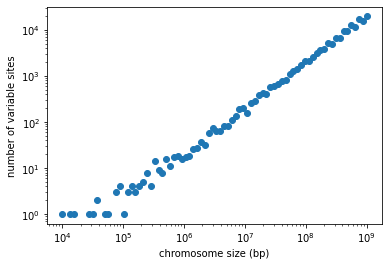

In [74]:
plt.scatter(np.array(res)[:,0], np.array(res)[:,1])
plt.xlabel('chromosome size (bp)')
plt.ylabel('number of variable sites')
plt.semilogy()
plt.semilogx()



Text(0, 0.5, 'number of gene trees')

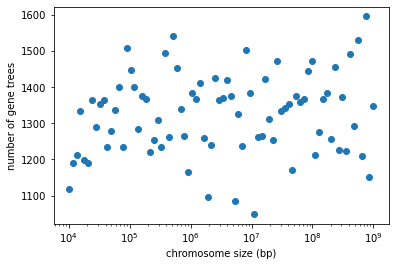

In [77]:
plt.scatter(np.array(res)[:,0], np.array(res)[:,2])
plt.semilogx()
plt.xlabel('chromosome size (bp)')
plt.ylabel('number of gene trees')

[]

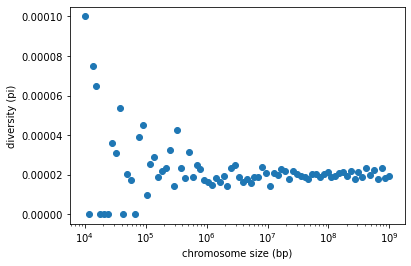

In [83]:
plt.scatter(np.array(res)[:,0], np.array(res)[:,1]/np.array(res)[:,0])
plt.xlabel('chromosome size (bp)')
plt.ylabel('diversity (pi)')
#plt.semilogy()
plt.semilogx()


In [3]:
path = "/home/kele/Documents/lai/lai-sim/results/simulations/AmericanAdmixture_4B11/AA_42/test_anal_1.sample.filter.tsz"
ts = tszip.decompress(path)

print(len(ts.samples()))
ts


400


In [10]:
!/home/kele/programs/bcftools/bcftools-1.11/bcftools view \
/home/kele/Documents/lai/lai-sim/results/local_ancestry/AmericanAdmixture_4B11/AA_42/test_anal_1.phased.target_inds.vcf.gz | \
  grep "|"  | sed 's/0|0/0/g' | sed 's/0|1/1/g' | sed 's/1|0/2/g' | sed 's/1|1/3/g' 
  

[W::vcf_parse] Contig 'chr22' is not defined in the header. (Quick workaround: index the file with tabix.)
chr22	1965	.	A	T	.	PASS	.	GT	0	2	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	1	0	0	0	3	0	2	0	2	1	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	1	0	0	0	0
chr22	5853	.	A	T	.	PASS	.	GT	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
chr22	8418	.	A	T	.	PASS	.	GT	0	0	0	0	0	0	0	0	0	0	0	3	0	0	2	1	2	0	0	0	1	0	0	0	2	0	2	2	0	0	1	3	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
chr22	9857	.	A	T	.	PASS	.	GT	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0
chr22	10635	.	A	T	.	PASS	.	GT	0	0	0	1	2	0	0	0	0	2	0	0	1	0	0	0	1	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	3	0	0
chr22	11416	.	A	T	.	PASS	.	GT	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
chr22	14419	.	A	T	.	PASS	.	GT	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	2	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0

In [1]:
import stdpopsim
chrom_id ='chr22'
chr_len = 1

species = stdpopsim.get_species("HomSap")
contig = species.get_contig(chrom_id, length_multiplier=chr_len)

In [2]:
contig.recombination_map.get_length()


51304566.0

In [ ]:
import stdpopsim
chrom_id ='chr22'
chr_len = .25

species = stdpopsim.get_species("HomSap")
contig = species.get_contig(chrom_id, length_multiplier=chr_len)
contig.recombination_map.get_length()


In [45]:
chrom_id ='chr22'
chr_len = .05

species = stdpopsim.get_species("HomSap")
contig = species.get_contig(chrom_id, length_multiplier=chr_len)

positions = [99, 12345, 421435]
rate = contig.recombination_map.get_ll_recombination_map().get_rates()[0] * 100 # convert to cM
cM_pos = [pos*rate for pos in positions]


In [52]:
contig.recombination_map.get_rates()

[1.4445022767788226e-08, 0.0]

In [24]:
pd.read_csv('/home/kele/Documents/lai/lai-sim/results/local_ancestry/AmericanAdmixture_4B11/AA_42/test_anal_1.genetic_map.txt',
           sep = '\t', header = None)[2].values

array([2.838000e-03, 8.455000e-03, 1.216000e-02, 1.423800e-02,
       1.536200e-02, 1.649000e-02, 2.082800e-02, 2.509400e-02,
       2.910800e-02, 3.193800e-02, 3.247800e-02, 3.385600e-02,
       4.250700e-02, 4.723800e-02, 5.096300e-02, 5.618500e-02,
       6.012500e-02, 6.073000e-02, 6.110000e-02, 7.280000e-02,
       7.415900e-02, 7.760400e-02, 8.319300e-02, 8.456700e-02,
       8.724900e-02, 8.927600e-02, 9.206800e-02, 9.291800e-02,
       9.852200e-02, 1.001040e-01, 1.014170e-01, 1.063470e-01,
       1.067760e-01, 1.069080e-01, 1.106680e-01, 1.127350e-01,
       1.355880e-01, 1.365560e-01, 1.371990e-01, 1.394070e-01,
       1.403310e-01, 1.428500e-01, 1.447030e-01, 1.468760e-01,
       1.562990e-01, 1.583460e-01, 1.625570e-01, 1.677170e-01,
       1.682310e-01, 1.696030e-01, 1.715870e-01, 1.719460e-01,
       1.726500e-01, 1.748820e-01, 1.780380e-01, 1.821760e-01,
       1.829950e-01, 1.921560e-01, 1.930490e-01, 1.962330e-01,
       1.963400e-01, 1.967820e-01, 1.997930e-01, 2.0889

In [25]:
!pwd

/home/kele/Documents/lai/lai-sim/workflow/notebooks


In [46]:
stdpopsim.__version__

'0.1.2'

In [44]:
rate

1.4445022767788225e-06

In [3]:
def get_local_ancestry(ts, admixture_time, per_batch):
    # target_samples are at time==0
    target_samples = np.intersect1d(
                ts.samples(),
                np.where(ts.tables.nodes.asdict()['time']==0)[0]
            )
    # target ancestors are at time==admixture_time
    target_ancestors = np.where(ts.tables.nodes.asdict()['time']==admixture_time)[0]
    
    nsample = len(target_samples)
    l = [x for x in range(0, nsample, per_batch)]
    r = [x for x in range(per_batch, nsample+per_batch, per_batch)]
    #print(l, r)
    dfs = []
    for i in range(len(l)):
        local = ts.tables.link_ancestors(          
            samples = target_samples[l[i]:r[i]],
            ancestors = target_ancestors
        )

        local_df = pd.DataFrame({
            'left': local.left, 
            'right': local.right,
            'parent': local.parent,
            'child': local.child
        })
        
        dfs.append(local_df)
        
    local_ancestry_df = pd.concat(dfs)
    pop_of_node = dict(zip(range(len(ts.tables.nodes)), ts.tables.nodes.population))
    # local ancestry population
    local_ancestry_df['localpop'] = [pop_of_node[x] for x in local_ancestry_df['parent']]
    # sampling population
    local_ancestry_df['samplepop'] = [pop_of_node[x] for x in local_ancestry_df['child']]
    local_ancestry_df = local_ancestry_df.sort_values(['samplepop', 'child', 'left']).reset_index(drop=True)
    return(local_ancestry_df)

In [3]:
ts = tszip.decompress('/home/kele/Documents/lai/lai-sim/results/simulations/AmericanAdmixture_4B11/AA_42/test_anal_1.sample.tsz')

print(len(ts.samples()))
ts

175114


In [37]:
tables = ts.tables
#tables.sites.ancestral_state = np.array(['A' for _ in tables.sites])
a, off = tskit.pack_strings(['A' for _ in tables.sites])
tables.sites.set_columns(position = tables.sites.position, ancestral_state = a, ancestral_state_offset = off)

t, off = tskit.pack_strings(['T' for _ in tables.mutations])

tables.mutations.set_columns(site=tables.mutations.site, 
                             node=tables.mutations.node, 
                             derived_state=a, 
                             derived_state_offset=off)

In [35]:
tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,438874,nan,T,-1,
1,1,13803,nan,T,-1,
2,2,278061,nan,T,-1,
3,3,346536,nan,T,-1,
4,4,177489,nan,T,-1,
5,5,281830,nan,T,-1,
6,6,351117,nan,T,-1,
7,7,146593,nan,T,-1,
8,8,49747,nan,T,-1,
9,9,283152,nan,T,-1,


In [12]:
[s.position for s in ts.sites()]

[1.2742944359779358,
 42.79837908688933,
 73.14186565345153,
 77.70543927233666,
 166.39498272514902,
 212.2924223949667,
 229.60578837851062,
 239.33020239695907,
 253.95831123087555,
 312.8965358028654,
 453.7063127136789,
 455.2432009463664,
 458.3674761727452,
 529.4313842137344,
 545.71736064367,
 599.1509334724396,
 646.1419532359578,
 686.763868689537,
 695.3500957749784,
 746.4046758699697,
 771.8510902135167,
 799.5224416851997,
 821.7596545377746,
 931.0459000070114,
 943.0218509614933,
 985.9024206802715,
 1025.9012150326744,
 1206.3463911088184,
 1281.6836734134704,
 1289.653668596875,
 1297.2256690599024,
 1338.5502100337762,
 1345.5442794265691,
 1351.3077791603282,
 1360.7574570556171,
 1369.024188055424,
 1382.8181520248763,
 1388.6979620996863,
 1423.6273282323964,
 1515.3275527425576,
 1523.703059512889,
 1553.7801657780074,
 1599.2533378293738,
 1638.2902904902585,
 1710.5155942104757,
 1742.9543086886406,
 1867.660406040959,
 1961.7500392948277,
 1965.4399013072252,

In [4]:
ts = tszip.decompress('/home/kele/Documents/lai/lai-sim/results/simulations/AmericanAdmixture_4B11/AA_42/test_anal_1.sample.filter.tsz')

print(len(ts.samples()))
ts

400


In [67]:
la = get_local_ancestry(ts, admixture_time=20, per_batch=12)
la

34


,left,right,parent,child,localpop,samplepop
0,0.0,1032662.0,17588,0,0,0
1,1032662.0,1502117.0,18959,0,0,0
2,1502117.0,1502437.0,2220,0,0,0
3,1502437.0,2065843.0,18959,0,0,0
4,2065843.0,2066010.0,14009,0,0,0
...,...,...,...,...,...,...
1940,73718.0,681222.0,61532,399,1,3
1941,681222.0,681617.0,57704,399,1,3
1942,681617.0,707838.0,61532,399,1,3
1943,707838.0,708216.0,57704,399,1,3


In [70]:
la.to_hdf('./temp.hdf', key = 'local_ancestry', mode = 'w', complib = 'blosc:lz4', format ='fixed')

/home/kele/Documents/lai/lai-sim/workflow/notebooks


ImportError: Missing optional dependency 'tables'.  Use pip or conda to install tables.

In [52]:
len(np.where(ts.tables.nodes.asdict()['time']==0)[0])

400

In [53]:
ts.tables.nodes.asdict()['time'][ts.samples()]

array([ 0.,  0.,  0., ..., 20., 20., 20.])

In [54]:
len(ts.samples())

175114

In [30]:
random_seed = 42


rng = default_rng(random_seed)
seeds = rng.bit_generator._seed_seq.spawn(10)

In [32]:
type(seeds)

list

In [27]:
rng = np.random.default_rng(seed)
rng.choice(range(9), 3, replace=False)

array([1, 3, 0])

In [28]:
rng.choice(range(9), 3, replace=False)

array([4, 3, 0])

In [29]:
rng.choice(range(9), 3, replace=False)

array([3, 0, 8])

In [3]:
ts = tszip.decompress('/home/kele/Documents/lai/lai-sim/results/sims/AmericanAdmixture_4B11/AA_42.full.tsz')

In [4]:
ts

In [22]:
take = np.array([], dtype = int)
per_pop = 14
for pop in ts.populations():
    samples = ts.samples(population = pop.id)[:per_pop]
    take = np.concatenate([take, samples])

In [23]:
take

array([     0,      1,      2,      3,      4,      5,      6,      7,
            8,      9,     10,     11,     12,     13,  28948,  28949,
        28950,  28951,  28952,  28953,  28954,  28955,  28956,  28957,
        28958,  28959,  28960,  28961,  91804,  91805,  91806,  91807,
        91808,  91809,  91810,  91811,  91812,  91813,  91814,  91815,
        91816,  91817, 174744, 174745, 174746, 174747, 174748, 174749,
       174750, 174751, 174752, 174753, 362754, 362755, 362756, 362757])

In [27]:
take[::2]

array([     0,      2,      4,      6,      8,     10,     12,  28948,
        28950,  28952,  28954,  28956,  28958,  28960,  91804,  91806,
        91808,  91810,  91812,  91814,  91816, 174744, 174746, 174748,
       174750, 174752, 362754, 362756])

In [24]:
simp_ts = ts.simplify(
    samples=take, 
    map_nodes=True, 
    filter_populations=False
)

In [26]:
simp_ts[0]

In [57]:
[1,1,3,4][-1:]

[4]

In [47]:
from numpy.random import default_rng
random_seed = 42
rng = default_rng(random_seed)

def sample_inds(ts, pop_id, nind):
    """return the haploid sample ids representing sampling nind individuals from pop_id in ts"""
    hap_samples = ts.samples(population = pop.id)
    # sample from the first haploids of each ind
    take = rng.choice(hap_samples[::2], nind, replace=False)
    samples = np.empty(nind*2, dtype=int)
    samples[0::2] = take
    samples[1::2] = take+1
    return(samples)
    

sample_inds(ts, 3, 18), sample_inds(ts, 2, 18)

(array([371680, 371681, 437354, 437355, 376066, 376067, 372022, 372023,
        443206, 443207, 441892, 441893, 408372, 408373, 464192, 464193,
        417488, 417489, 407764, 407765, 416116, 416117, 372536, 372537,
        439250, 439251, 430796, 430797, 452014, 452015, 383692, 383693,
        435252, 435253, 444488, 444489]),
 array([409088, 409089, 441564, 441565, 441766, 441767, 379922, 379923,
        428418, 428419, 451974, 451975, 433238, 433239, 455616, 455617,
        391518, 391519, 435580, 435581, 463678, 463679, 443688, 443689,
        369806, 369807, 448788, 448789, 382984, 382985, 369378, 369379,
        400588, 400589, 399606, 399607]))

In [61]:
a = sample_inds(ts, 2, 18)
a.sort()
a

array([378580, 378581, 379510, 379511, 380026, 380027, 387572, 387573,
       394098, 394099, 402364, 402365, 409136, 409137, 410760, 410761,
       414278, 414279, 414454, 414455, 414836, 414837, 425890, 425891,
       428288, 428289, 433842, 433843, 435144, 435145, 437292, 437293,
       456378, 456379, 460274, 460275])

In [ ]:
c = np.empty((a.size + b.size), dtype=a.dtype)
c[0::2] = a
c[1::2] = b

In [50]:
import os 
import pandas as pd

In [28]:
np.empty(4)

array([4.66610009e-310, 0.00000000e+000, 6.92363728e-310, 6.92353203e-310])

In [52]:
os.chdir('/home/kele/Documents/lai/lai-sim')

In [53]:
config= dict()
config["simulations"] = 'config/simulations.tsv'
config["analyses"] =  'config/analyses.tsv'

In [55]:
# this file has one line per base simulation run
# up through the recap and mutate step
simulations = pd.read_csv(config["simulations"], sep="\t")
analyses = pd.read_csv(config["analyses"], sep="\t")
units = analyses.merge(simulations, on=['sim_name'])
units

,anal_name,sim_name,nsamp_admixed,nsamp_ref,MAC_filter,max_snps,model_name,random_seed,slim_script_path,ancestral_Ne,mutation_rate,chr,chr_len
0,test_anal_1,AA_42,50,50,5,10000,AmericanAdmixture_4B11,42,workflow/scripts/sim/SLiM/AmericanAdmixture_4B...,7310,1.440000e-08,chr22,0.25


In [44]:
next(simulations.itertuples()).sim_name

'AA_42'

In [45]:
simulations

,sim_name,model_name,random_seed,slim_script_path,ancestral_Ne,mutation_rate,chr,chr_len
sim_name,,,,,,,,
AA_42,AA_42,AmericanAdmixture_4B11,42,../workflow/scripts/sim/SliM/AmericanAdmixture...,7310,1.440000e-08,chr22,0.25
AA_52,AA_52,AmericanAdmixture_4B11,52,workflow/scripts/sim/SliM/AmericanAdmixture_4B...,7310,1.440000e-08,chr22,0.25


In [46]:
[f'results/sims/{s.model_name}/{s.sim_name}.full.tsz' for s in simulations.itertuples()]

['results/sims/AmericanAdmixture_4B11/AA_42.full.tsz',
 'results/sims/AmericanAdmixture_4B11/AA_52.full.tsz']

In [30]:
#units = analyses.merge(simulations, on = ['sim_name'])
#units = units.set_index(['sim_name', 'anal_name'])
units

,anal_name,sim_name,nsamp_admixed,nsamp_ref,MAC_filter,max_snps,model_name,random_seed,slim_script_path,ancestral_Ne,mutation_rate,chr,chr_len
0,test_anal_1,AA_42,50,50,5,10000,AmericanAdmixture_4B11,42,workflow/scripts/sim/SliM/AmericanAdmixture_4B...,7310,1.440000e-08,chr22,0.25


In [25]:
simulations

,model_name,random_seed,slim_script_path,ancestral_Ne,mutation_rate,chr,chr_len
sim_name,,,,,,,
AA_42,AmericanAdmixture_4B11,42,workflow/scripts/sim/SliM/AmericanAdmixture_4B...,7310,1.440000e-08,chr22,0.25
AA_52,AmericanAdmixture_4B11,52,workflow/scripts/sim/SliM/AmericanAdmixture_4B...,7310,1.440000e-08,chr22,0.25


In [28]:
analyses

,sim_name,nsamp_admixed,nsamp_ref,MAC_filter,max_snps
anal_name,,,,,
test_anal_1,AA_42,50,50,5,10000


In [48]:
units

NameError: name 'units' is not defined

In [23]:
units.loc[('AA_42', 'test_anal_1')]

nsamp_admixed                                                      50
nsamp_ref                                                          50
MAC_filter                                                          5
max_snps                                                        10000
model_name                                     AmericanAdmixture_4B11
random_seed                                                        42
slim_script_path    workflow/scripts/sim/SliM/AmericanAdmixture_4B...
ancestral_Ne                                                     7310
mutation_rate                                                     0.0
chr                                                             chr22
chr_len                                                          0.25
Name: (AA_42, test_anal_1), dtype: object

,,nsamp_admixed,nsamp_ref,MAC_filter,max_snps,model_name,random_seed,slim_script_path,ancestral_Ne,mutation_rate,chr,chr_len
sim_name,anal_name,,,,,,,,,,,
AA_42,test_anal_1,50,50,5,10000,AmericanAdmixture_4B11,42,workflow/scripts/sim/SliM/AmericanAdmixture_4B...,7310,1.440000e-08,chr22,0.25


In [14]:
[f'results/sims/{u.model_name}/{u.sim_name}.full.tsz' for u in units.itertuples()]

['results/sims/AmericanAdmixture_4B11/AA_42.full.tsz']

In [7]:
	.set_index("sim_name", drop=False)
	.sort_index()
)

# this file has one line per analysis run
# each line should reference a simulation
# specifies the sampling and filtering
# may also specify a limited genomic span?? (probably not worth it)
# we will have to see how best to specify the LAI parameters

	.set_index("anal_name", drop=False)
	.sort_index()
)

ValueError: 'sim_name' is both an index level and a column label, which is ambiguous.